
## Questions to Guide the EDA

1. **Population & Density**
   - How are **population** and **population density** distributed across districts?
   - Which **states** host the most/least populous and densest districts?

2. **Sex Ratio & Literacy**
   - What are the distributions of **sex ratio** and **literacy rate** across districts?
   - Which districts are **top/bottom 10** on these indicators?

3. **Urbanization**
   - How does **% urban population** vary across districts and states?
   - Are highly urban districts systematically different on literacy or sex ratio?

4. **Relationships**
   - Is **literacy** correlated with **sex ratio**?
   - Is **population density** correlated with **urban share**?

5. **Regional Patterns**
   - Which states show **consistent strengths/weaknesses** across indicators?
   - Are there **clusters** of districts with similar profiles? (basic correlation/clustering intuition)

6. **Data Quality**
   - Missing values or odd zeros?
   - Inconsistent naming (districts/states)?
   - Outliers that may reflect **genuine extremes** vs. **data errors**?

### Hypotheses (to test/inspect)
- **H1:** Districts with **higher literacy** tend to have a **higher sex ratio**.
- **H2:** Districts with **higher population density** are **more urbanized** on average.
- **H3:** States with **higher median literacy** also exhibit **lower dispersion** in literacy (greater equality).



## Load Data & Inspect Structure
We'll try to auto-detect the **district-level** CSV (commonly named like `india-districts-census-2011.csv`). If multiple candidates are present, we will print them.


In [25]:

import pandas as pd
import numpy as np
import os, glob, re

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 120)

district_file = os.path.join(os.getcwd(), 'EDA_DATA', 'india-districts-census-2011.csv')
df = pd.read_csv(district_file)
print("\nShape:", df.shape)


print(df.columns.to_list())



Shape: (640, 118)
['District code', 'State name', 'District name', 'Population', 'Male', 'Female', 'Literate', 'Male_Literate', 'Female_Literate', 'SC', 'Male_SC', 'Female_SC', 'ST', 'Male_ST', 'Female_ST', 'Workers', 'Male_Workers', 'Female_Workers', 'Main_Workers', 'Marginal_Workers', 'Non_Workers', 'Cultivator_Workers', 'Agricultural_Workers', 'Household_Workers', 'Other_Workers', 'Hindus', 'Muslims', 'Christians', 'Sikhs', 'Buddhists', 'Jains', 'Others_Religions', 'Religion_Not_Stated', 'LPG_or_PNG_Households', 'Housholds_with_Electric_Lighting', 'Households_with_Internet', 'Households_with_Computer', 'Rural_Households', 'Urban_Households', 'Households', 'Below_Primary_Education', 'Primary_Education', 'Middle_Education', 'Secondary_Education', 'Higher_Education', 'Graduate_Education', 'Other_Education', 'Literate_Education', 'Illiterate_Education', 'Total_Education', 'Age_Group_0_29', 'Age_Group_30_49', 'Age_Group_50', 'Age not stated', 'Households_with_Bicycle', 'Households_with_


## Basic Cleaning & Schema Normalization

- Strip/normalize column names (lowercase, underscores)
- Trim string fields
- Identify numeric columns and coerce types


In [26]:

# Normalize column names
df.columns = (
    df.columns
    .str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    .str.lower()
)

# Trim obvious text fields
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# Attempt to coerce numeric columns that look numeric
for col in df.columns:
    if df[col].dtype == "object":
        # Try numeric conversion (ignore obvious IDs/names)
        if not any(key in col for key in ["name", "state", "district", "code"]):
            df[col] = pd.to_numeric(df[col].str.replace(",", ""), errors="ignore")

# Quick schema snapshot
schema = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str),
    "n_missing": df.isna().sum().values,
    "n_unique": [df[c].nunique() for c in df.columns]
}).sort_values("column").reset_index(drop=True)

schema.head(10)


,column,dtype,n_missing,n_unique
0,age_group_0_29,int64,0,640
1,age_group_30_49,int64,0,640
2,age_group_50,int64,0,639
3,age_not_stated,int64,0,606
4,agricultural_workers,int64,0,640
5,below_primary_education,int64,0,640
6,buddhists,int64,0,511
7,christians,int64,0,622
8,condition_of_occupied_census_houses_dilapidate...,int64,0,635
9,cultivator_workers,int64,0,639



## Data Quality Checks

- Missing values
- Potential duplicate districts
- Zero/negative values in key indicators


In [27]:

# Missing values summary
missing = df.isna().sum().sort_values(ascending=False).to_frame("n_missing")
missing["pct_missing"] = (missing["n_missing"] / len(df)).round(4)
display(missing.head(20))

# Duplicates (by district + state if available)
district_key_candidates = [c for c in df.columns if "district" in c] or [c for c in df.columns if "name" in c]
state_key_candidates = [c for c in df.columns if "state" in c]

dup_df = pd.DataFrame()
if district_key_candidates:
    dkey = district_key_candidates[0]
    if state_key_candidates:
        skey = state_key_candidates[0]
        dup_df = df[df.duplicated([dkey, skey], keep=False)].sort_values([dkey, skey])
    else:
        dup_df = df[df.duplicated(dkey, keep=False)].sort_values(dkey)

if not dup_df.empty:
    print("⚠️ Potential duplicate rows:")
    display(dup_df.head(20))
else:
    print("No obvious duplicate rows based on district/state keys.")

# Suspicious zero/negative values in common metrics (best-effort guesses)
suspect_cols = [c for c in df.columns if any(k in c for k in ["population", "density", "literacy", "sex_ratio", "urban", "female", "male"])]
suspicious = {}
for c in suspect_cols:
    try:
        vals = pd.to_numeric(df[c], errors="coerce")
        suspicious[c] = {
            "n_zero": int((vals == 0).sum()),
            "n_negative": int((vals < 0).sum()),
            "min": float(np.nanmin(vals)),
            "max": float(np.nanmax(vals))
        }
    except Exception:
        pass

pd.DataFrame(suspicious).T.sort_index()


,n_missing,pct_missing
district_code,0,0.0
state_name,0,0.0
district_name,0,0.0
population,0,0.0
male,0,0.0
female,0,0.0
literate,0,0.0
male_literate,0,0.0
female_literate,0,0.0
sc,0,0.0


No obvious duplicate rows based on district/state keys.


,n_zero,n_negative,min,max
female,0.0,0.0,3590.0,5195070.0
female_literate,0.0,0.0,1822.0,3635765.0
female_sc,32.0,0.0,0.0,1197528.0
female_st,55.0,0.0,0.0,787545.0
female_workers,0.0,0.0,1327.0,1239177.0
male,0.0,0.0,4414.0,5865078.0
male_literate,0.0,0.0,2614.0,4591396.0
male_sc,31.0,0.0,0.0,1266504.0
male_st,55.0,0.0,0.0,793305.0
male_workers,0.0,0.0,2228.0,3363123.0



## Univariate Analysis of Population, Education, and Household Amenities


In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Helper function for histogram
def hist_plot(series, title, xlabel):
    s = pd.to_numeric(series, errors="coerce").dropna()
    plt.figure(figsize=(8, 5))
    plt.hist(s, bins=30, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.grid(alpha=0.3)
    plt.show()

# Key numeric columns to visualize
key_columns = {
    "Population": "Population",
    "Male Population": "Male",
    "Female Population": "Female",
    "Literate Population": "Literate",
    "Workers": "Workers",
    "Graduate Education": "Graduate_Education",
    "Households with Internet": "Households_with_Internet",
    "Households with TV": "Households_with_Television"
}

# Plot histograms
for title, col in key_columns.items():
    if col in df.columns:
        hist_plot(df[col], f"Distribution of {title}", col)
    else:
        print(f"(Note) Column '{col}' not found in dataset.")


(Note) Column 'Population' not found in dataset.
(Note) Column 'Male' not found in dataset.
(Note) Column 'Female' not found in dataset.
(Note) Column 'Literate' not found in dataset.
(Note) Column 'Workers' not found in dataset.
(Note) Column 'Graduate_Education' not found in dataset.
(Note) Column 'Households_with_Internet' not found in dataset.
(Note) Column 'Households_with_Television' not found in dataset.



## Top/Bottom Districts

District Rankings for Key Socio-Economic Indicators

In [24]:
def top_bottom(df, metrics, ascending=False):
    for metric in metrics:
        if metric in df.columns:
            s = pd.to_numeric(df[metric], errors="coerce")
            out = df.assign(_metric=s).dropna(subset=["_metric"]).sort_values("_metric", ascending=ascending)
            
            # Select columns to show: district + state if available
            cols_to_show = [c for c in df.columns if any(k in c.lower() for k in ["district", "state", "name"])]
            cols_to_show = (cols_to_show[:2] if len(cols_to_show) >= 2 else cols_to_show) + [metric, "_metric"]
            
            top10 = out.tail(10)[cols_to_show]
            bot10 = out.head(10)[cols_to_show]
            
            print(f"\n=== {metric.upper()} ===")
            print("\nTop 10 districts:")
            display(top10)
            print("\nBottom 10 districts:")
            display(bot10)
        else:
            print(f"(Note) No column found for '{metric}'.")

# Call with actual numeric columns
metrics_to_check = ["Population", "Male", "Female"]  
top_bottom(df, metrics_to_check, ascending=True)


(Note) No column found for 'Population'.
(Note) No column found for 'Male'.
(Note) No column found for 'Female'.



## Bivariate Analysis: Correlations and Hypothesis Testing

This section explores relationships between key variables using pairwise correlation analysis. We compute correlation coefficients to assess the strength and direction of associations and visualize these relationships through scatter plots with fitted linear trendlines. Simple statistical tests are also applied to validate observed patterns.


Correlation matrix (Pearson):


,Literacy_Rate,Sex_Ratio,Urban_Share
Literacy_Rate,1.000000,0.150428,0.562127
Sex_Ratio,0.150428,1.000000,-0.121329
Urban_Share,0.562127,-0.121329,1.000000


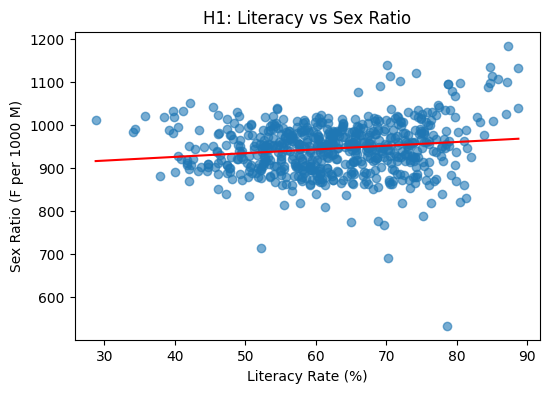

Pearson r = 0.150


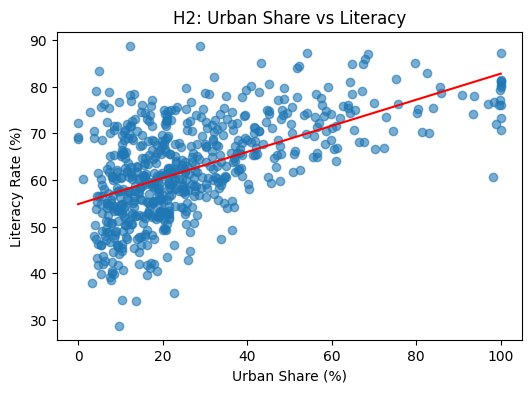

Pearson r = 0.562


In [18]:
# Compute derived metrics
df["Literacy_Rate"] = (pd.to_numeric(df["Literate"], errors="coerce") /
                        pd.to_numeric(df["Population"], errors="coerce")) * 100

df["Sex_Ratio"] = (pd.to_numeric(df["Female"], errors="coerce") /
                   pd.to_numeric(df["Male"], errors="coerce")) * 1000

df["Urban_Share"] = (pd.to_numeric(df["Urban_Households"], errors="coerce") /
                      pd.to_numeric(df["Households"], errors="coerce")) * 100

# Select metrics for correlation
corr_targets = ["Literacy_Rate", "Sex_Ratio", "Urban_Share"]
corr_df = df[corr_targets].dropna()
print("Correlation matrix (Pearson):")
display(corr_df.corr())

# Scatter with trend function
import numpy as np
import matplotlib.pyplot as plt

def scatter_with_trend(x, y, xlab, ylab, title):
    xs = pd.to_numeric(x, errors="coerce")
    ys = pd.to_numeric(y, errors="coerce")
    mask = xs.notna() & ys.notna()
    xs, ys = xs[mask], ys[mask]
    if len(xs) < 3:
        print(f"Insufficient data to plot {title}")
        return
    plt.figure(figsize=(6,4))
    plt.scatter(xs, ys, alpha=0.6)
    # Trendline
    m, b = np.polyfit(xs, ys, 1)
    plt.plot(np.linspace(xs.min(), xs.max(), 100), m*np.linspace(xs.min(), xs.max(), 100)+b, color='red')
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()
    r = np.corrcoef(xs, ys)[0,1]
    print(f"Pearson r = {r:.3f}")

# H1: Literacy vs Sex Ratio
scatter_with_trend(df["Literacy_Rate"], df["Sex_Ratio"], "Literacy Rate (%)", "Sex Ratio (F per 1000 M)", "H1: Literacy vs Sex Ratio")

# H2: Urban Share vs Literacy
scatter_with_trend(df["Urban_Share"], df["Literacy_Rate"], "Urban Share (%)", "Literacy Rate (%)", "H2: Urban Share vs Literacy")



## State-level Aggregation & Profiles

We'll compute state-level summaries (median & IQR) for key metrics to see regional patterns and dispersion (relevant to **H3**).


In [ ]:

# Identify state and district columns
state_col = None
for c in df.columns:
    if c.startswith("state"):
        state_col = c
        break

if not state_col:
    # Try a generic match
    for c in df.columns:
        if "state" in c:
            state_col = c
            break

metrics = []
for key in ["literacy", "sex_ratio", "density", "urban_share_auto"]:
    col = [c for c in df.columns if key in c]
    if col:
        metrics.append(col[0])

if state_col and metrics:
    agg = df.groupby(state_col)[metrics].apply(lambda x: pd.DataFrame({
        "median": x.median(numeric_only=True),
        "iqr": (x.quantile(0.75, numeric_only=True) - x.quantile(0.25, numeric_only=True))
    })).unstack()
    display(agg.head(20))
else:
    print("State-level aggregation skipped (missing state column or metrics).")



## Outlier Detection (Anomalies)

We flag districts with **z-score > 3** for key numeric metrics. These may be genuine extremes or potential data issues worth a closer look.


In [ ]:

from scipy import stats

num_df = df.select_dtypes(include=[np.number]).copy()
z = np.abs(stats.zscore(num_df, nan_policy="omit"))
z = pd.DataFrame(z, columns=num_df.columns, index=num_df.index)

outlier_flags = (z > 3).sum(axis=1)
outliers = df.loc[outlier_flags > 0].copy()
outliers["n_outlier_metrics"] = outlier_flags[outlier_flags > 0]

print(f"Found {len(outliers)} potential outlier rows (z>3 on at least one numeric column).")
display(outliers.head(20))



## Findings Summary & Next Steps

**What we looked at**
- Data dictionary & types; missingness; duplicates
- Distributions for population, density, sex ratio, literacy, urbanization
- Top/bottom districts
- Correlations (H1/H2) and simple trendlines
- State-level dispersion (H3)
- Outlier districts

**Potential Issues / Fixes**
- **Missing values:** consider imputation strategy (median within state) or drop if sparse.
- **Inconsistent naming:** standardize state/district names using authoritative code lists.
- **Derived metrics:** compute `urban_share = urban_population / total_population * 100` if not provided.
- **Outliers:** verify if they are true extremes (e.g., major metros) vs. data entry errors.

**Next Steps**
- Enrich with **geospatial data** for mapping (district centroids are available in some Kaggle variants).
- Build state-wise dashboards (e.g., with Plotly) and carry out deeper **inequality** analyses (Gini, Theil).
- Extend to **temporal comparisons** if 2001 data is available to analyze changes.
